<a href="https://colab.research.google.com/github/Mehrads/NLP-method/blob/main/nlp_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/Mehrads/NLP-method"

Cloning into 'NLP-method'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 21), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (51/51), 98.86 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.6 MB/s eta 0:00:00


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Project/Suicide_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
data["Unnamed: 0"].value_counts().max()

1

In [7]:
data["class"].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

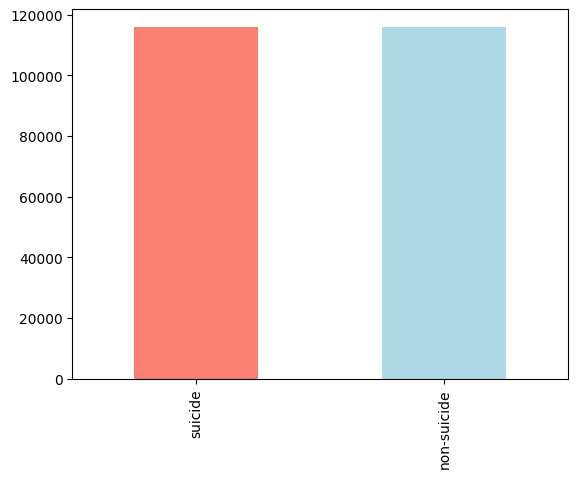

In [8]:
data["class"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [9]:
data = data.drop("Unnamed: 0", axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [10]:
data["text"][1]

"Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it"

In [11]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42)

In [12]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        #sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
np.random.seed(42)
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:02<00:00, 19351.94it/s]


In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [15]:
import pickle

with open('/content/drive/MyDrive/Project/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

In [17]:
word_freq.iloc[:30]

,word,count
11,im,262218
3,dont,170780
114,like,144424
139,want,119519
4,know,104463
348,feel,97903
126,life,93692
9,ive,83425
20,cant,81579
57,people,73812


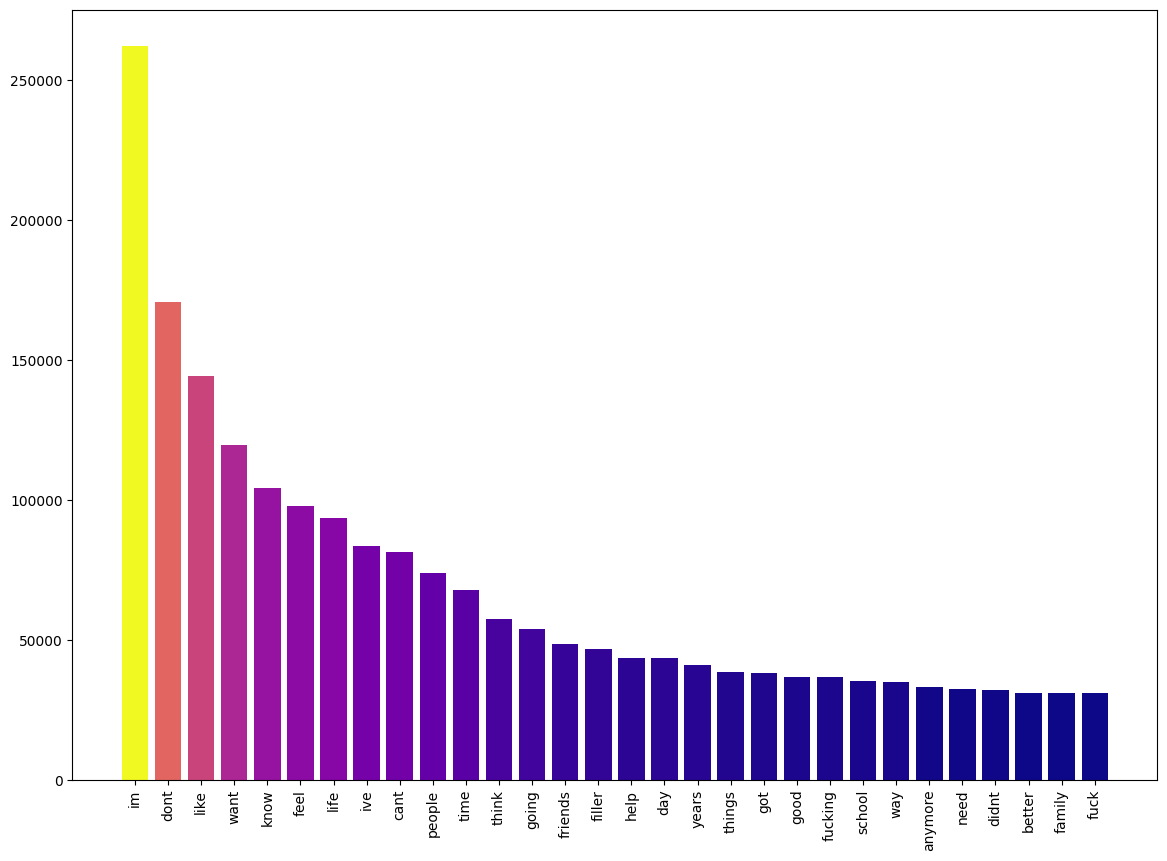

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))
my_cmap = plt.get_cmap("plasma")
y = word_freq["count"].iloc[:30]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
ax.bar(x=word_freq["word"].iloc[:30], height=word_freq["count"].iloc[:30], color=my_cmap(rescale(y)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

In [19]:
np.random.seed(42)
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
np.random.seed(42)
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [21]:
with open('/content/drive/MyDrive/Project/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [22]:
np.random.seed(42)
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [23]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [24]:
np.random.seed(42)

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            # This Dense layer's units will be dynamically set in the call method
            tf.keras.layers.Dense(head_size),  # Placeholder, will adjust dynamically
        ])
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        # Dynamically set the output dimension of the last Dense layer to match input dimension
        self.ffn.layers[-1].units = inputs.shape[-1]
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)


# Define your model architecture here
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,)),
    tf.keras.layers.Embedding(v+1, 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(20, return_sequences=True),
    TransformerEncoder(head_size=128, num_heads=4, ff_dim=512, dropout=0.1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.09),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
np.random.seed(42)
hybrid_model = model.fit(train_text_pad, train_output,
              validation_data=(test_text_pad, test_output),
              epochs=19,
              batch_size=256,
              callbacks=[early_stop, reducelr])

Epoch 1/19
726/726 [==============================] - 25s 24ms/step - loss: 0.3379 - accuracy: 0.8563 - val_loss: 0.2516 - val_accuracy: 0.8999 - lr: 0.1000
Epoch 2/19
726/726 [==============================] - 17s 23ms/step - loss: 0.2451 - accuracy: 0.9027 - val_loss: 0.2294 - val_accuracy: 0.9094 - lr: 0.1000
Epoch 3/19
726/726 [==============================] - 17s 23ms/step - loss: 0.2115 - accuracy: 0.9177 - val_loss: 0.2549 - val_accuracy: 0.8981 - lr: 0.1000
Epoch 4/19
726/726 [==============================] - 17s 23ms/step - loss: 0.1872 - accuracy: 0.9273 - val_loss: 0.2177 - val_accuracy: 0.9154 - lr: 0.1000
Epoch 5/19
726/726 [==============================] - 19s 26ms/step - loss: 0.1746 - accuracy: 0.9320 - val_loss: 0.2046 - val_accuracy: 0.9200 - lr: 0.1000
Epoch 6/19
726/726 [==============================] - 18s 25ms/step - loss: 0.1677 - accuracy: 0.9340 - val_loss: 0.1876 - val_accuracy: 0.9267 - lr: 0.1000
Epoch 7/19
726/726 [==============================] - 17s 

Saving our model

In [26]:
saved_model = model.save('/content/drive/MyDrive/Project/Model/hybrid_model.h5')
saved_model_tf = model.save('/content/drive/MyDrive/Project/Model/hybrid_model_tf', save_format='tf')

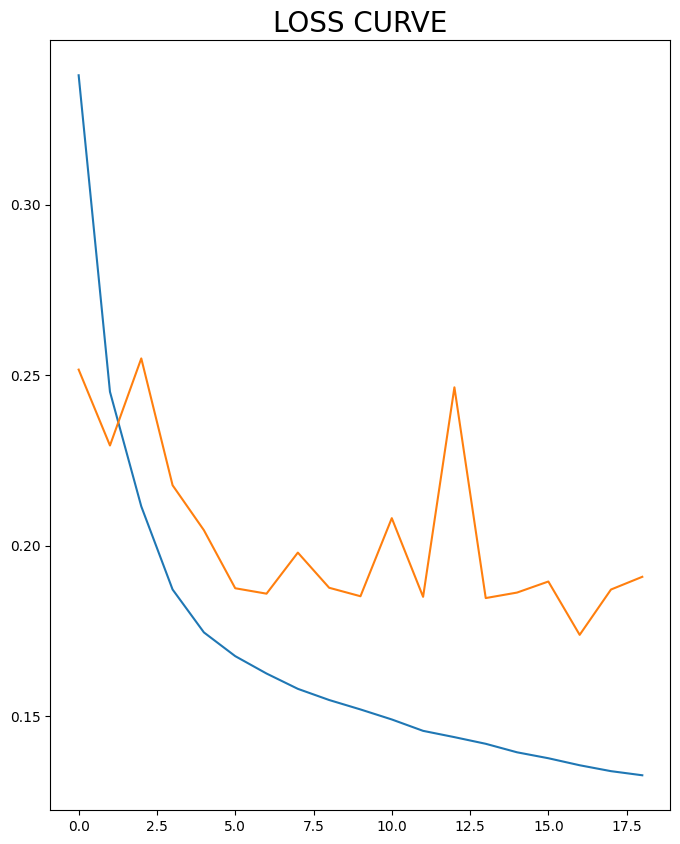

In [27]:
plt.figure(figsize=(8,10))
plt.plot(hybrid_model.history['loss'])
plt.plot(hybrid_model.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [28]:
predictions_test = (model.predict(test_text_pad) > 0.5).astype(int)
predictions_train = (model.predict(train_text_pad) > 0.5).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,predictions_test,
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,predictions_train,
                           target_names=lbl_target.inverse_transform([0,1])))

5802/5802 [==============================] - 29s 5ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.96      0.88      0.92     23287
     suicide       0.89      0.97      0.93     23128

    accuracy                           0.92     46415
   macro avg       0.93      0.92      0.92     46415
weighted avg       0.93      0.92      0.92     46415

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.98      0.89      0.93     92750
     suicide       0.90      0.98      0.94     92909

    accuracy                           0.93    185659
   macro avg       0.94      0.93      0.93    185659
weighted avg       0.94      0.93      0.93    185659



In [30]:
hybrid_model = load_model('/content/drive/MyDrive/Project/Model/hybrid_model.h5', custom_objects={'TransformerEncoder': TransformerEncoder})
with open('/content/drive/MyDrive/Project/tokenizer.pkl', 'rb') as t:
    tokenizers = pickle.load(t)

In [32]:
text = "I want to kill myself"


def clean_text_single(text):
    text = text.lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    return text

# Clean your single text input
cleaned_text = clean_text_single(text)

# Tokenize and pad
sequence = tokenizers.texts_to_sequences([cleaned_text])  # Note the list wrapping
padded_sequence = pad_sequences(sequence, maxlen=50)


# Predict
prediction = hybrid_model.predict(padded_sequence)

# Interpret the prediction
threshold = 0.5
classified_output = "suicide" if prediction[0][0] > threshold else "non-suicide"
print(f"Classification result: {classified_output}")

1/1 [==============================] - 0s 33ms/step
Classification result: suicide
